In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # For rectangles
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats # For linregress (trends)
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '../../../') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.8.2 | packaged by conda-forge | (default, Feb 28 2020, 17:15:22) 
[GCC 7.3.0]
Virtual memory usage - total: 252 GB / available: 227 GB / percent used: 9.9 %


# Check the surface variables first
In particular the snow cover

In [4]:
path = '/data/mlalande/gpfsstore/rech/lmd/rlmd007/IGCM_OUT/LMDZOR/TEST/clim/TEST-RELIEF-NEW/SRF/Output/MO'

# Get the snow cover
Attention calendrier 360d

In [15]:
path = '/data/mlalande/gpfsstore/rech/lmd/rlmd007/IGCM_OUT/LMDZOR/TEST/clim/TEST-RELIEF-NEW/SRF/Output/MO'
grid = xr.open_mfdataset(path+'/*.nc', combine='by_coords').frac_snow.mean('time_counter')

In [11]:
latlim=(10,50)
lonlim=(60,110)

var_label = 'Snow cover extent [%]'
cmap='BuRd'
levels=plot.arange(-50,50,10)

In [6]:
path = '/data/mlalande/gpfsstore/rech/lmd/rlmd007/IGCM_OUT/LMDZOR/TEST/clim/TEST-RELIEF-NEW/SRF/Output/MO'
snc_new_Laurent = xr.open_mfdataset(path+'/*.nc', combine='by_coords').frac_snow.mean('time_counter').sel(lat=slice(50,10), lon=slice(60,110))

path = '/data/mlalande/gpfsstore/rech/lmd/rlmd007/IGCM_OUT/LMDZOR/TEST/clim/TEST-RELIEF-00/SRF/Output/MO'
snc_Laurent = xr.open_mfdataset(path+'/*.nc', combine='by_coords').frac_snow.mean('time_counter').sel(lat=slice(50,10), lon=slice(60,110))

path = '/data/mlalande/gpfsstore/rech/goe/ufz23bm/IGCM_OUT/LMDZOR/PROD/clim/clim-relief-def/SRF/Output/MO'
snc = xr.open_mfdataset(path+'/*.nc', combine='by_coords').frac_snow.mean('time_counter').sel(lat=slice(50,10), lon=slice(60,110))

# path = '/data/mlalande/gpfsstore/rech/lmd/rlmd007/IGCM_OUT/LMDZOR/TEST/clim/TEST-RELIEF-NEW/SRF/Output/MO'
# snc_new_Laurent = xr.open_mfdataset(path+'/*.nc', combine='by_coords').frac_snow.mean('time_counter')

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


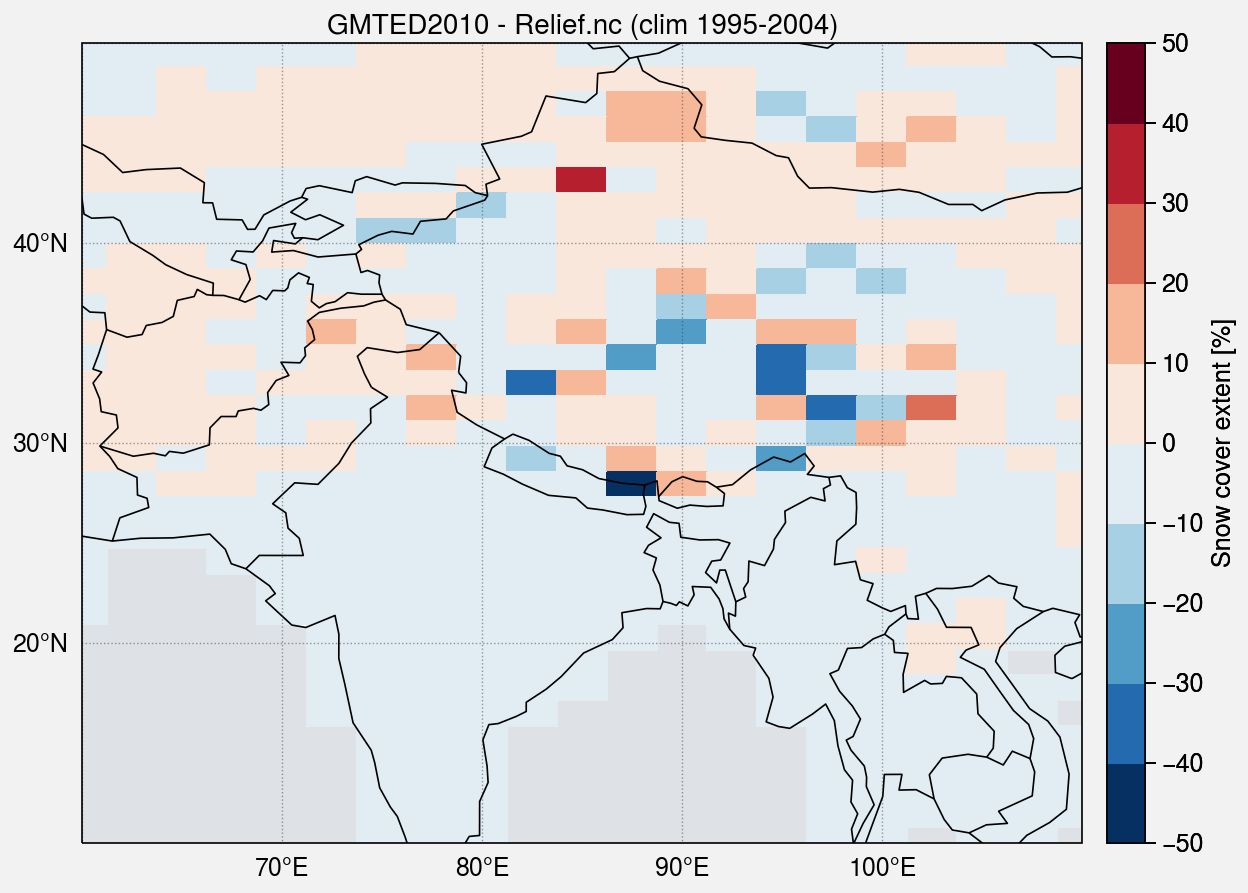

In [14]:
f, axs = plot.subplots(ncols=1, nrows=1, proj='cyl', axwidth=5)

m = axs[0].pcolormesh((snc_new_Laurent-snc_Laurent), cmap=cmap, levels=levels)
axs[0].format(title='GMTED2010 - Relief.nc (clim 1995-2004)')
f.colorbar(m, label=var_label)

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
#     suptitle="",
    lonlines=10, latlines=10, abc=False, latlim=latlim, lonlim=lonlim
)

# f.save('.png')
# f.save('.pdf')

# Load obs
(see http://localhost:7227/notebooks/notebooks/CICLAD/Himalaya/CMIP6_IPSL_bias/Snow%20cover.ipynb)

In [17]:
obs_longname = 'NOAA Climate Data Record (CDR) Version 1'
obs_name = 'NOAA CDR'

In [16]:
ds_rutger = xr.open_dataset('/data/mlalande/RUTGERS/nhsce_v01r01_19661004_20191202.nc').sel(time=slice('1995','2004'))
with xr.set_options(keep_attrs=True):
    obs = ds_rutger.snow_cover_extent.where(ds_rutger.land == 1)*100
obs.attrs['units'] = '%'
obs = obs.rename({'longitude': 'lon', 'latitude': 'lat'})
obs = obs.resample(time='1MS').mean('time', skipna='False', keep_attrs=True)

# For adding NaN values outside of the grid, otherwise it puts 0 (see issue just up #15)
import scipy
def add_matrix_NaNs(regridder):
    X = regridder.weights
    M = scipy.sparse.csr_matrix(X)
    num_nonzeros = np.diff(M.indptr)
    M[num_nonzeros == 0, 0] = np.NaN
    regridder.weights = scipy.sparse.coo_matrix(M)
    return regridder

# Make the regrider
regridder_obs = xe.Regridder(obs, grid, 'bilinear', periodic=False, reuse_weights=True)
regridder_obs = add_matrix_NaNs(regridder_obs)

# Regrid the data
obs_regrid = regridder_obs(obs)

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/xarray/core/resample.py:176: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  super().__init__(*args, **kwargs)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Create weight file: bilinear_88x88_143x144.nc


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [20]:
obs_regrid.mean('time').sel(lat=slice(50,10), lon=slice(60,110))

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'snow_cover_extent' (lat: 143, lon: 144)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    snow_cover_threshold  float32 0.42
  * lon                   (lon) float32 -180.0 -177.5 -175.0 ... 175.0 177.5
  * lat                   (lat) float32 90.0 88.73239 ... -88.73239 -90.0

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


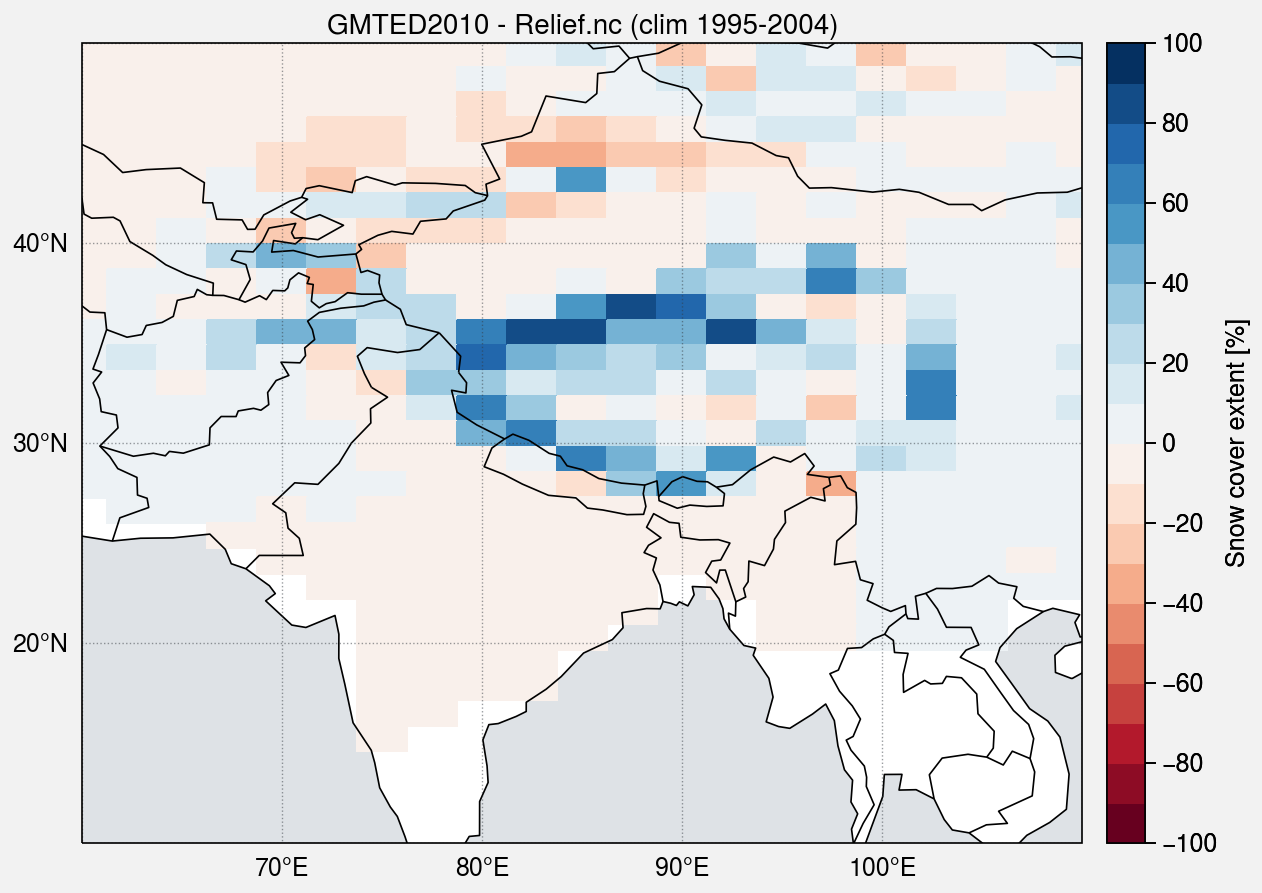

In [23]:
f, axs = plot.subplots(ncols=1, nrows=1, proj='cyl', axwidth=5)

m = axs[0].pcolormesh((snc_new_Laurent-obs_regrid.mean('time').sel(lat=slice(50,10), lon=slice(60,110))), cmap='RdBu', levels=plot.arange(-100,100,10))
axs[0].format(title='GMTED2010 - Relief.nc (clim 1995-2004)')
f.colorbar(m, label=var_label)

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
#     suptitle="",
    lonlines=10, latlines=10, abc=False, latlim=latlim, lonlim=lonlim
)

# f.save('.png')
# f.save('.pdf')

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


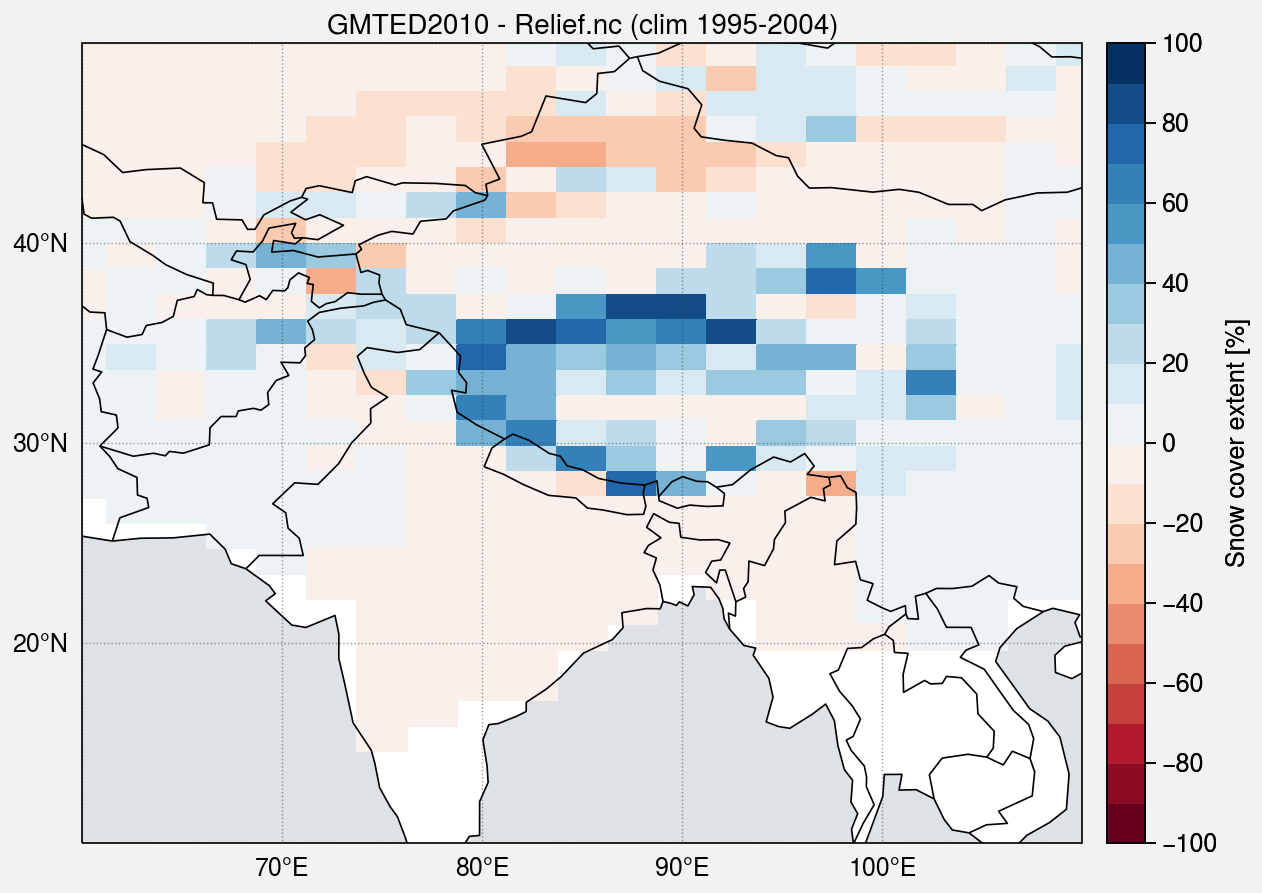

In [24]:
f, axs = plot.subplots(ncols=1, nrows=1, proj='cyl', axwidth=5)

m = axs[0].pcolormesh((snc_Laurent-obs_regrid.mean('time').sel(lat=slice(50,10), lon=slice(60,110))), cmap='RdBu', levels=plot.arange(-100,100,10))
axs[0].format(title='GMTED2010 - Relief.nc (clim 1995-2004)')
f.colorbar(m, label=var_label)

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
#     suptitle="",
    lonlines=10, latlines=10, abc=False, latlim=latlim, lonlim=lonlim
)

# f.save('.png')
# f.save('.pdf')

# Check back std

In [33]:
std_topo = xr.open_dataarray('~/notebooks/CICLAD/Himalaya/CMIP6_IPSL_bias/std_topo.nc').sel(lat=slice(10,50), lon=slice(60,110))

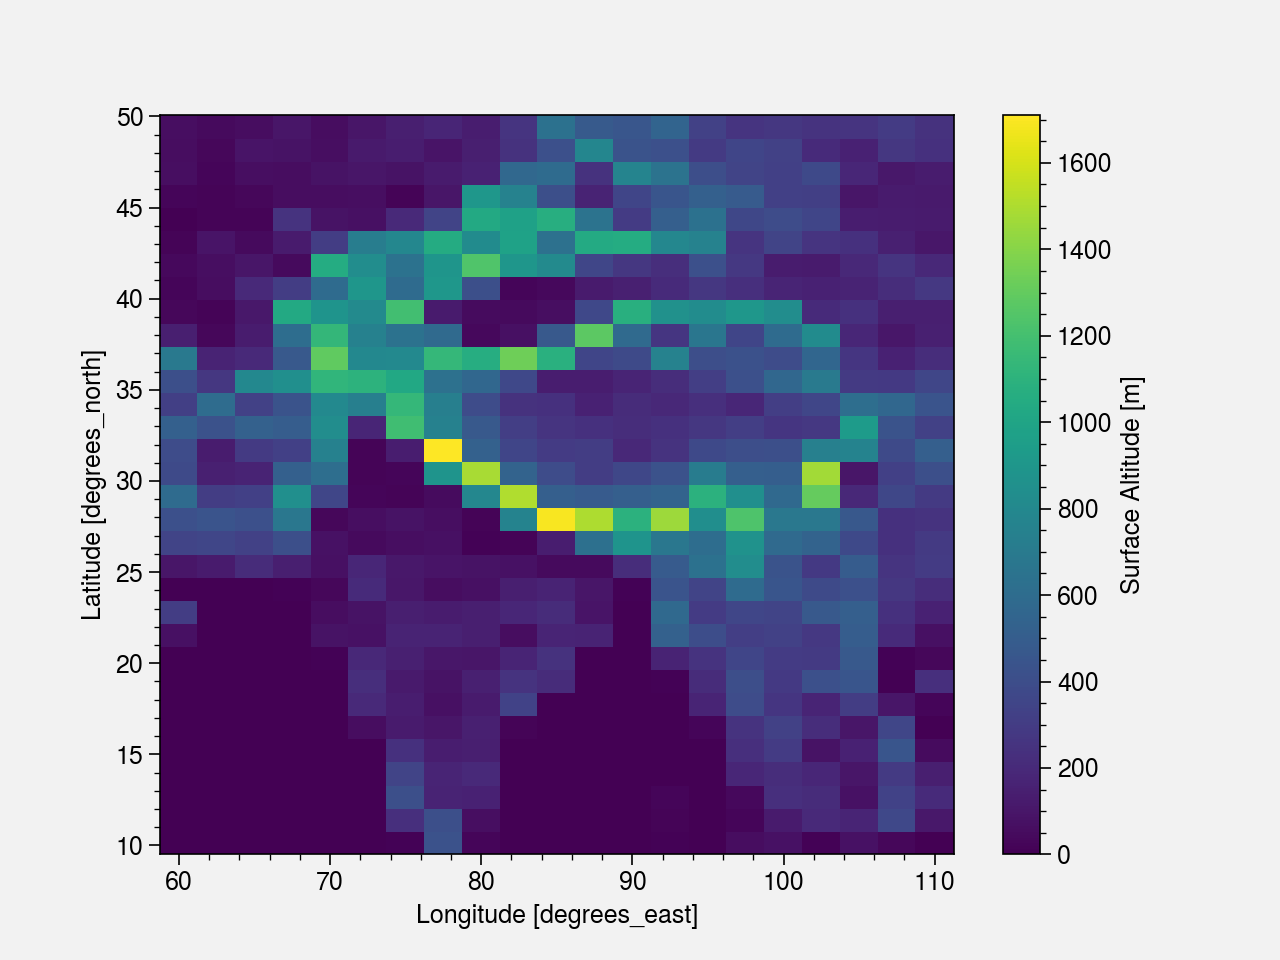

In [38]:
std_topo.plot()

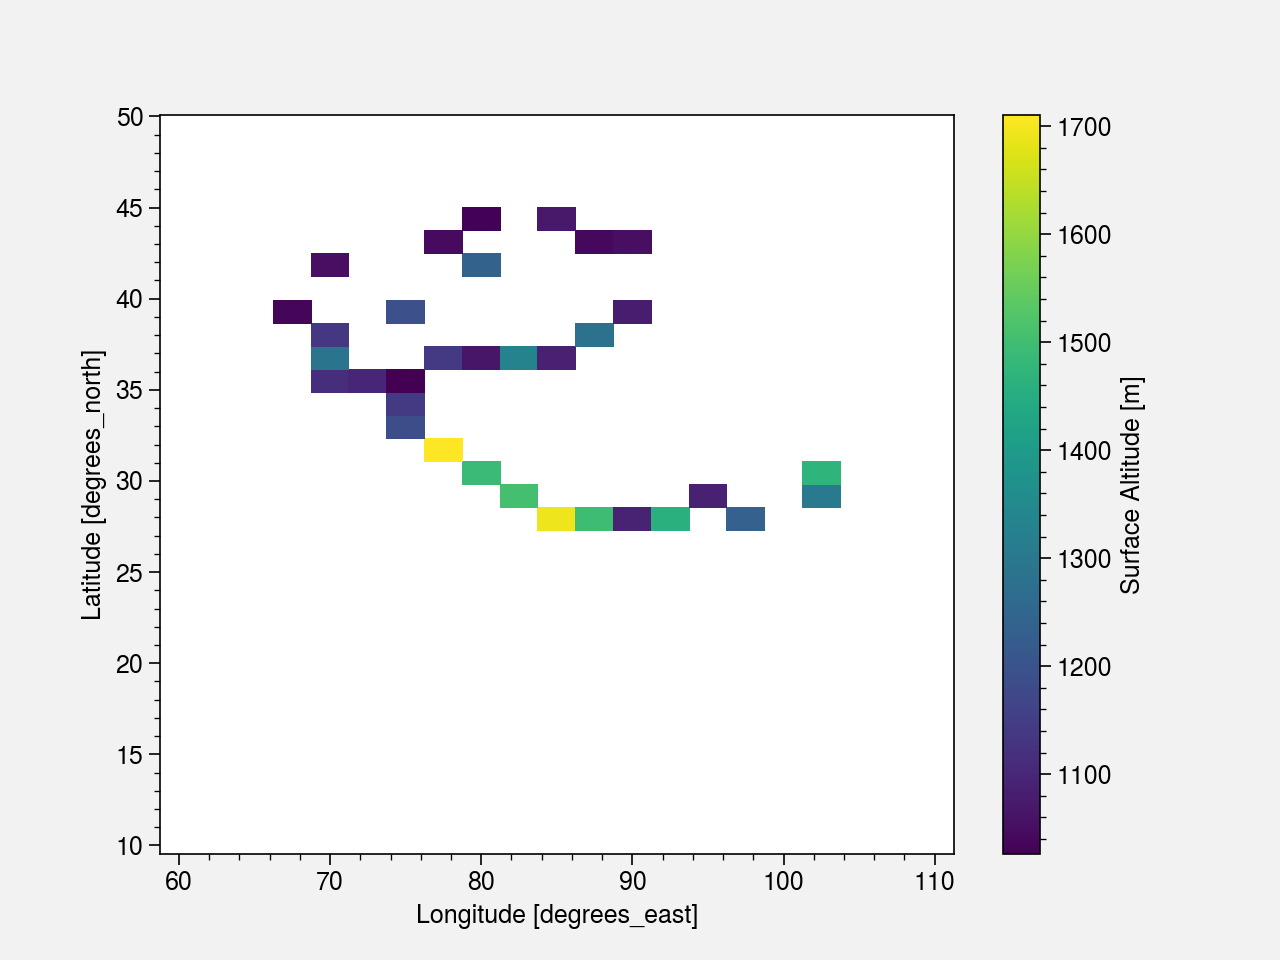

In [37]:
std_topo.where(std_topo > 1000).plot()

In [39]:
bias = (snc_new_Laurent-obs_regrid.mean('time').sel(lat=slice(50,10), lon=slice(60,110)))

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


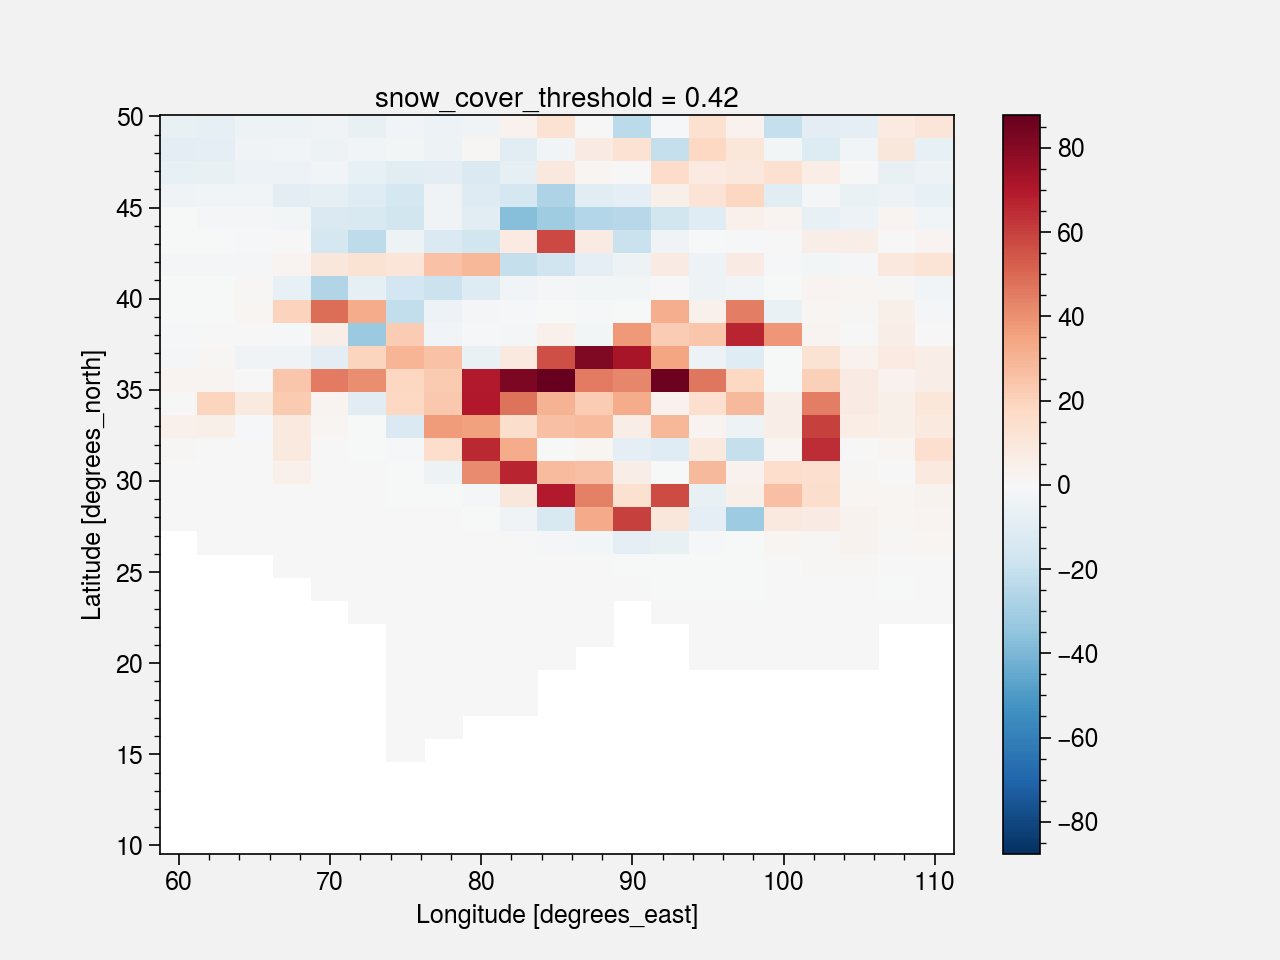

In [46]:
bias.plot()

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


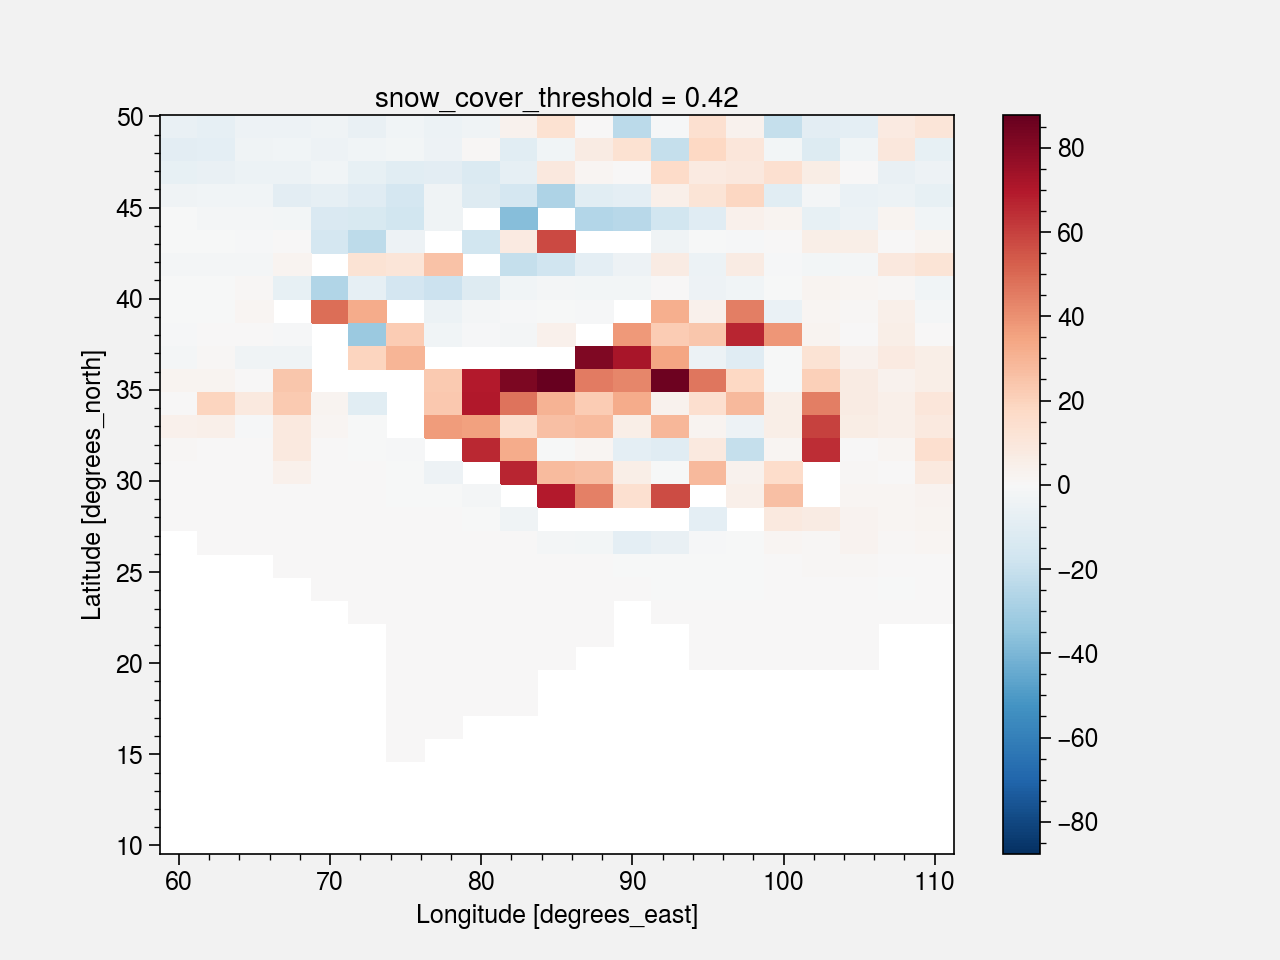

In [49]:
bias.where(std_topo < 1000).plot()

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


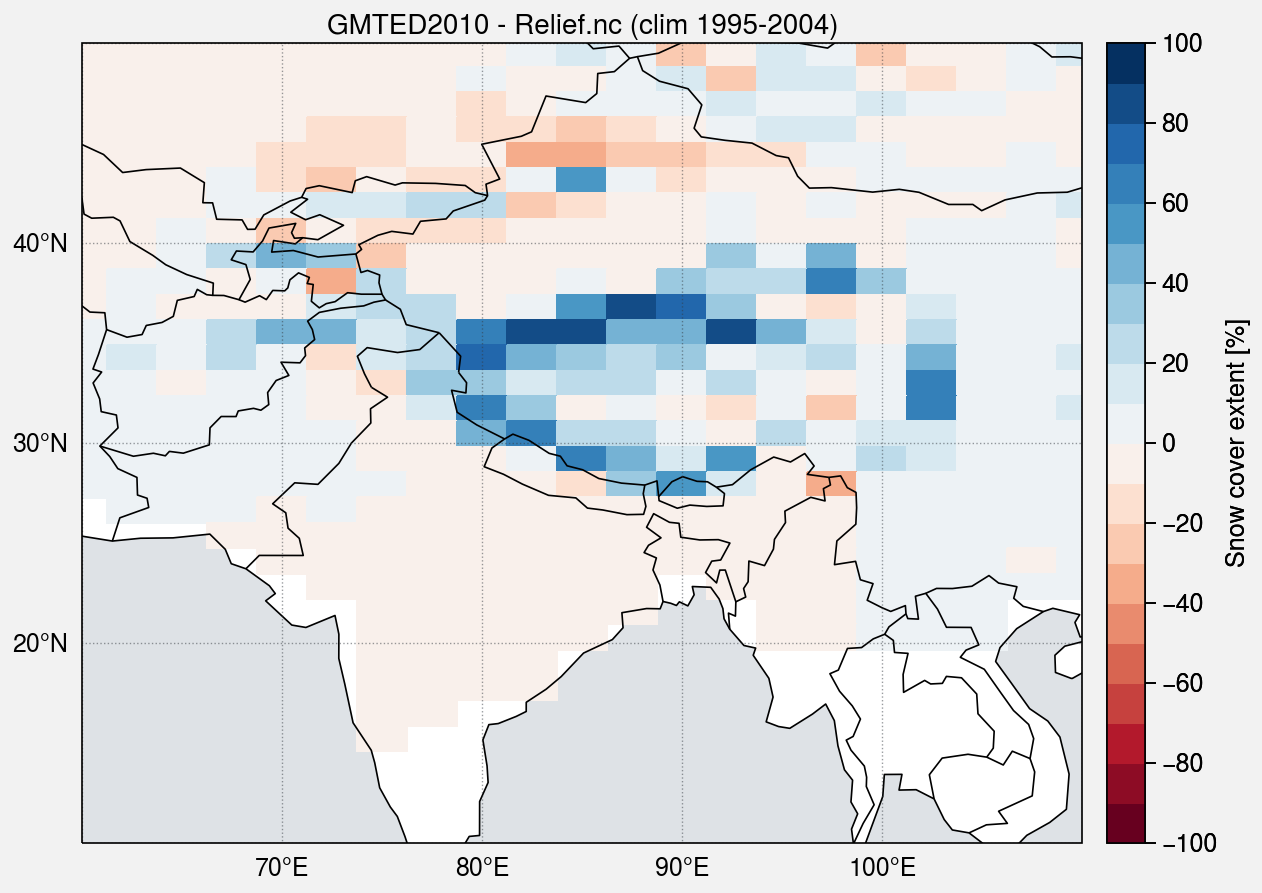

In [50]:
f, axs = plot.subplots(ncols=1, nrows=1, proj='cyl', axwidth=5)

m = axs[0].pcolormesh(bias, cmap='RdBu', levels=plot.arange(-100,100,10))
axs[0].format(title='GMTED2010 - Relief.nc (clim 1995-2004)')
f.colorbar(m, label=var_label)

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
#     suptitle="",
    lonlines=10, latlines=10, abc=False, latlim=latlim, lonlim=lonlim
)

# f.save('.png')
# f.save('.pdf')

In [64]:
std_topo.sortby('lat', ascending=False).lat

<xarray.DataArray 'lat' (lat: 32)>
array([49.43662 , 48.169014, 46.90141 , 45.633804, 44.366196, 43.09859 ,
       41.830986, 40.56338 , 39.295776, 38.028168, 36.760563, 35.492958,
       34.225353, 32.957745, 31.690142, 30.422535, 29.15493 , 27.887323,
       26.619719, 25.352112, 24.084507, 22.816902, 21.549295, 20.28169 ,
       19.014084, 17.746479, 16.478872, 15.211267, 13.943662, 12.676056,
       11.408451, 10.140845], dtype=float32)
Coordinates:
  * lat      (lat) float32 49.43662 48.169014 46.90141 ... 11.408451 10.140845
Attributes:
    axis:           Y
    standard_name:  latitude
    long_name:      Latitude
    units:          degrees_north

In [61]:
bias.sortby('lat').lat

<xarray.DataArray 'lat' (lat: 32)>
array([10.140845, 11.408451, 12.676056, 13.943662, 15.211267, 16.478872,
       17.746479, 19.014084, 20.28169 , 21.549295, 22.816902, 24.084507,
       25.352112, 26.619719, 27.887323, 29.15493 , 30.422535, 31.690142,
       32.957745, 34.225353, 35.492958, 36.760563, 38.028168, 39.295776,
       40.56338 , 41.830986, 43.09859 , 44.366196, 45.633804, 46.90141 ,
       48.169014, 49.43662 ], dtype=float32)
Coordinates:
  * lat                   (lat) float32 10.140845 11.408451 ... 49.43662
    snow_cover_threshold  float32 0.42
Attributes:
    axis:           Y
    standard_name:  latitude
    long_name:      Latitude
    units:          degrees_north

In [67]:
bias.where(std_topo.sortby('lat', ascending=False) < 1000, -500)

<xarray.DataArray (lat: 32, lon: 21)>
dask.array<where, shape=(32, 21), dtype=float64, chunksize=(32, 21), chunktype=numpy.ndarray>
Coordinates:
  * lat                   (lat) float32 49.43662 48.169014 ... 10.140845
  * lon                   (lon) float32 60.0 62.5 65.0 ... 105.0 107.5 110.0
    snow_cover_threshold  float32 0.42

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


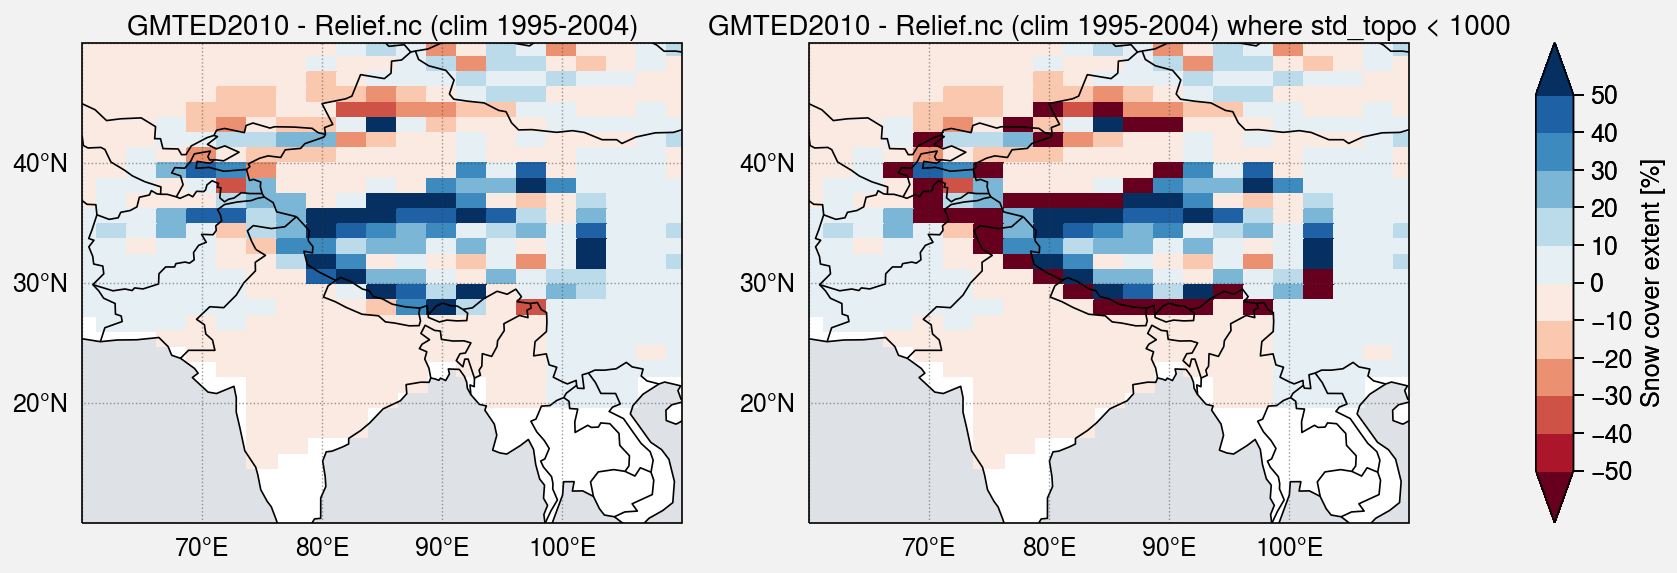

In [68]:
f, axs = plot.subplots(ncols=2, nrows=1, proj='cyl', axwidth=3)

m = axs[0].pcolormesh(bias, cmap='RdBu', levels=plot.arange(-50,50,10), extend='both')
axs[0].format(title='GMTED2010 - Relief.nc (clim 1995-2004)')

axs[1].pcolormesh(bias.where(std_topo.sortby('lat', ascending=False) < 1000, -500), cmap='RdBu', levels=plot.arange(-50,50,10), extend='both')
axs[1].format(title='GMTED2010 - Relief.nc (clim 1995-2004) where std_topo < 1000')

f.colorbar(m, label=var_label)

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
#     suptitle="",
    lonlines=10, latlines=10, abc=False, latlim=latlim, lonlim=lonlim
)

# f.save('.png')
# f.save('.pdf')

In [69]:
std_topo_global = xr.open_dataarray('~/notebooks/CICLAD/Himalaya/CMIP6_IPSL_bias/std_topo.nc')

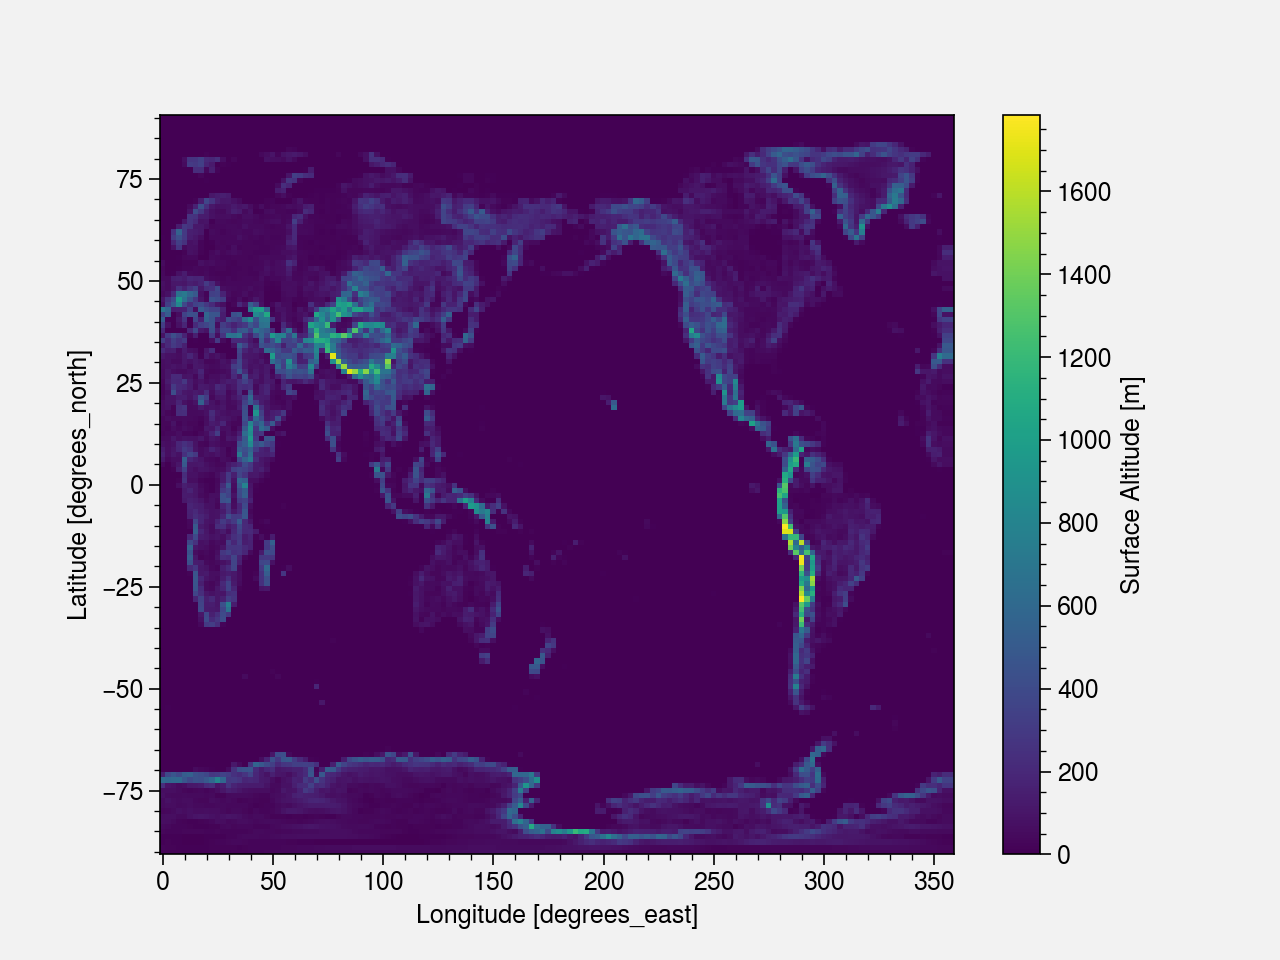

In [70]:
std_topo_global.plot()

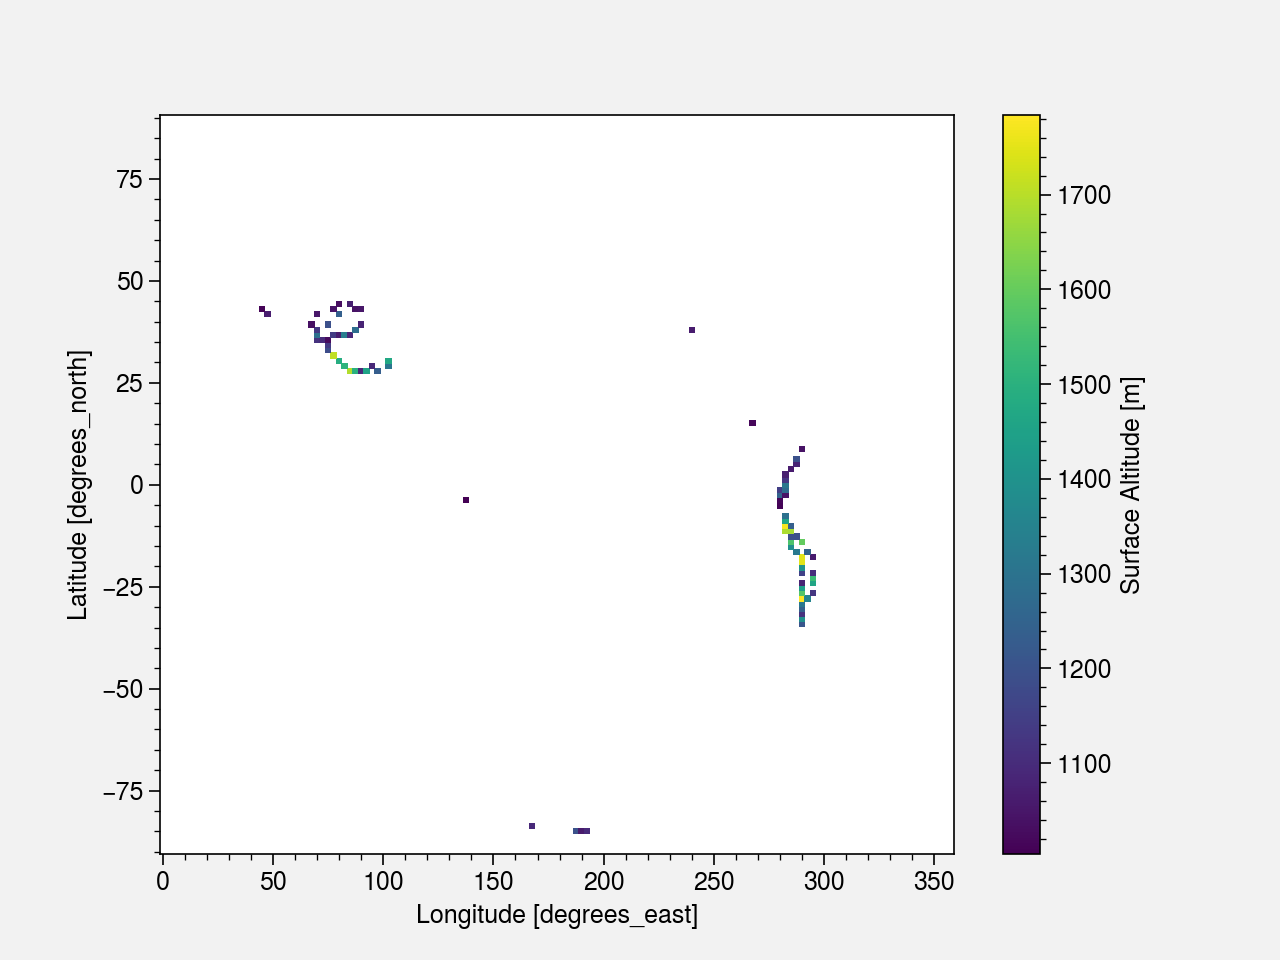

In [71]:
std_topo_global.where(std_topo_global > 1000).plot()